In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import h5py
import os
import torch
import tensorboard
%load_ext tensorboard

from sklearn.model_selection import train_test_split
from mae_visualize_utils import *
from mae_visualize import *
from util.datasets import *
from util.pos_embed import *
from models_mae import *
from torch.utils.data import Subset

%load_ext autoreload
%autoreload 2

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.8/site-packages/apex/pyprof/__init__.py:5: FutureWarning: pyprof will be removed by the end of June, 2022
  warnings.warn("pyprof will be removed by the end of June, 2022", FutureWarning)


# RISE Exploratory

In [ ]:
# load data
########### specify options
patch_size = [1, 60]
normalization=False
data_path ="/niddk-data-central/mae_hr/rise_moca_4AP_20s_transition"
test_data = True
data = "RISE"
transform=False
RISE_hz = 30
alt=True
###########

patch_num = None
patch_size1, patch_size2 = patch_size

if test_data:
    if data == "RISE":
        dataset = RISE(data_path=data_path, is_test=True, normalization=normalization,
                        normalization_chan=False, RISE_hz=RISE_hz,
                            mix_up=False, alt=alt, transform=transform)
        labels = ["sedentary", "standing", "stepping", "cycling", "primary_lying", "secondary_lying", "seated_transport"]
        ids = torch.load(os.path.join(data_path, "id_test_test.pt"))
    elif data == "UCIHAR":
        dataset = UCIHAR(data_path=data_path, is_test=True, normalization=normalization,
                        normalization_chan=False, mix_up=False, alt=alt, transform=transform)
        
        labels = ['Transition', 'Walking', 'Walking-upstairs', 'Walking-downstairs', 'Sitting', 'Standing', 'Laying']
else:
    if data == "RISE":
        dataset = RISE(data_path=data_path, is_test=False, normalization=normalization,
                        normalization_chan=False, RISE_hz=RISE_hz,
                            mix_up=False, alt=alt, transform=transform)
        labels = ["sedentary", "standing", "stepping", "cycling", "primary_lying", "secondary_lying", "seated_transport"]
        ids = torch.load(os.path.join(data_path, "id_train.pt"))
    elif data == "UCIHAR":
        dataset = UCIHAR(data_path=data_path, is_test=False, normalization=normalization,
                        normalization_chan=False, mix_up=False, alt=alt, transform=transform)    
    labels = ['Transition', 'Walking', 'Walking-upstairs', 'Walking-downstairs', 'Sitting', 'Standing', 'Laying']

input_size = [dataset[0][0].shape[1], dataset[0][0].shape[2]]

if int(input_size[1]/patch_size2) !=patch_num:
    patch_num = int(input_size[1]/patch_size2)


in_chans = dataset[0][0].shape[0]

print(f"input_size: {input_size}, patch_size:{patch_size}, patch_num: {patch_num}, in_chans: {in_chans}")
print(dataset.shape)

In [7]:
# 30 Hz, 10 seconds
input_length = 300


start = 0    # start with start=100 and 0


# concatenated look
x_list = list()
y_list = list()
z_list = list()
label_list = list()
ids_list = list()

# we want to cut by 540000 data points = 30Hz*60*60*5
# n_hours plot -> 60*60*5 = 18000
n_hours = 12
data_point_length = 60*60*n_hours
hours_in_input = int(data_point_length/input_length)
for m in range(start, start+hours_in_input):
    data, label = dataset[m]
    sub_id = ids[m]
    x_list.append(data[0,0,:])
    y_list.append(data[0,1,:])
    z_list.append(data[0,2,:])
    label_list.append(np.repeat(label, data.shape[2]))
    ids_list.append(np.repeat((sub_id/10000), data.shape[2]))

x_data = torch.cat(x_list, dim=0)
y_data = torch.cat(y_list, dim=0)
z_data = torch.cat(z_list, dim=0)
label_data = torch.cat(label_list, dim=0)
id_data = torch.cat(ids_list, dim=0)
print(x_data.shape, y_data.shape, z_data.shape)

torch.Size([43200]) torch.Size([43200]) torch.Size([43200])


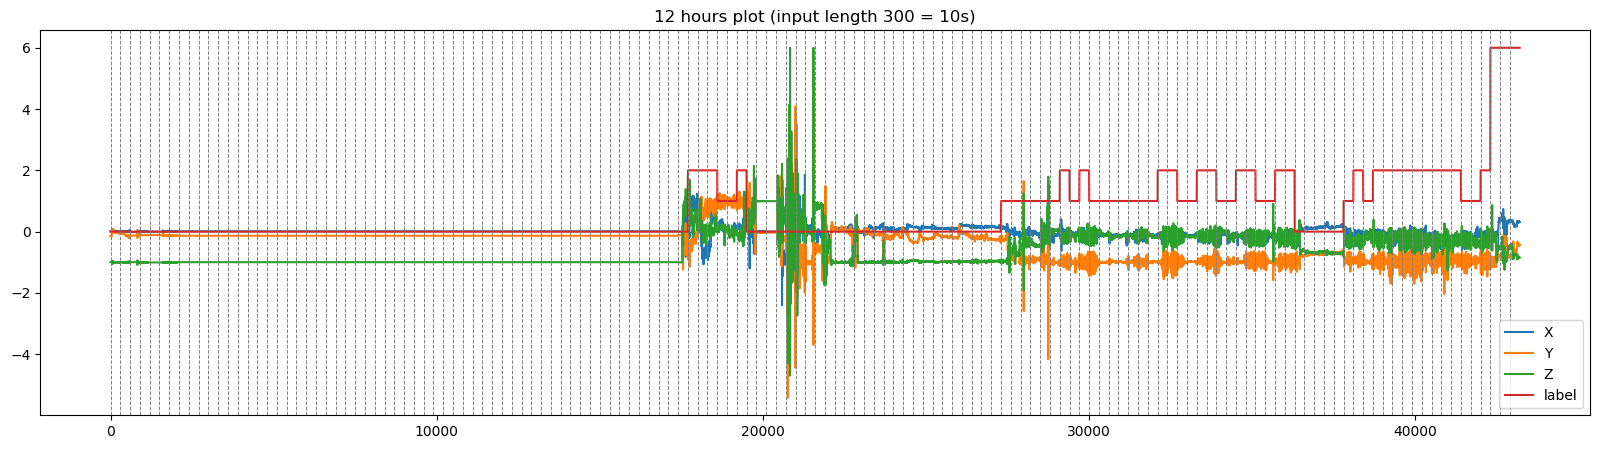

In [8]:
# n_hours hours plot
plt.figure(figsize=(20,5))
plt.plot(x_data, label="X")
plt.plot(y_data, label="Y")
plt.plot(z_data, label="Z")
plt.plot(label_data, label="label")
#plt.plot(id_data, label="id")
for x in range(0, x_data.shape[0], input_length):
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.7)
plt.legend()
plt.title(f"{n_hours} hours plot (input length {input_length} = {input_length//RISE_hz}s)")
plt.show()


label_names = ["sedentary", "standing", "stepping", "cycling", "primary_lying", "secondary_lying", "seated_transport"]

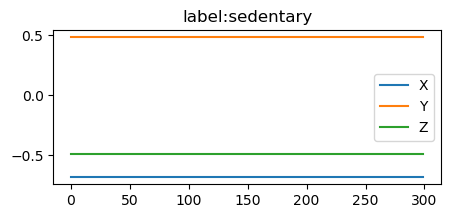

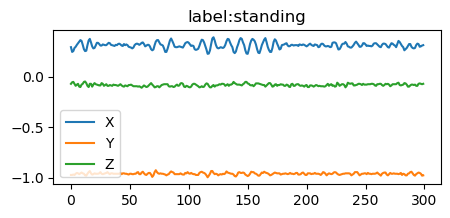

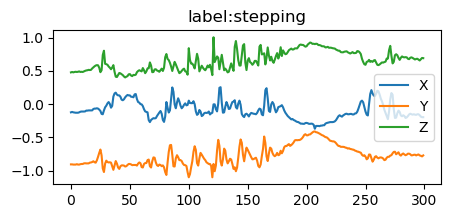

IndexError: index 2000 is out of bounds for axis 0 with size 501

In [9]:
# individual look (k'th data for labels)
label_names = ["sedentary", "standing", "stepping", "cycling", "primary_lying", "secondary_lying", "seated_transport"]
k=2000
for j in range(7):
    m = np.where(dataset.y == j)[0][k]
    data, label = dataset[m]
    #data1, label1 = dataset[m+1]
    plt.figure(figsize=(5,2))
    plt.plot(data[0,0,:], label="X")
    plt.plot(data[0,1,:], label="Y")
    plt.plot(data[0,2,:], label="Z")
    #plt.plot(np.repeat(label, data.shape[2]), label="label")
    plt.title(f"label:{label_names[j]}")
    plt.legend()
    plt.show()

## demographic

In [ ]:
trt_info = pd.read_csv("/Users/howonryu/Projects/MAE_Accelerometer/MAE_Accelerometer/MAE_APP/P2_3arm_rand.csv")
train_test_split = pd.read_csv("/Users/howonryu/Projects/MAE_Accelerometer/MAE_Accelerometer/MAE_APP/P2_train_test_rand.csv")

demo_info = trt_info.merge(train_test_split, on="study_id")

len(np.unique(demo_info['study_id']))

In [16]:
print(demo_info.loc[demo_info['type'] == "test_set"]['rand_assignment'].value_counts())
print(demo_info.loc[demo_info['type'] == "train_set"]['rand_assignment'].value_counts())

rand_assignment
0    35
2    34
1    26
Name: count, dtype: int64
rand_assignment
1    110
2    101
0    100
Name: count, dtype: int64


In [ ]:
#TODO: get demographic variables (age, bmi)

## original data (not downsampled)

In [23]:
from MAE_APP.rise_mae_preprocess import *
data_path = "/Users/howonryu/Projects/MAE_Accelerometer/MAE_Accelerometer/MAE_APP/pre_processed_mae_10s_vis"
data_vis_test, label_vis_test, id_vis_test, visit_vis_test = RISE_mae_pre_process(data_path=data_path, ids=[200483, 201755, 241100], downsample_ratio=1, device='cpu')


print(data_vis_test.shape, label_vis_test.shape)


Using device: cpu
Skipping 200483BL: folder does not exist. (1/6)
Processing 200483FV (2/6)
Skipping 201755BL: folder does not exist. (3/6)
Processing 201755FV (4/6)
Skipping 241100BL: folder does not exist. (5/6)
Processing 241100FV (6/6)
torch.Size([39666, 300, 3]) torch.Size([39666])


In [25]:
# 30 Hz, 10 seconds
input_length = 300
n_hours = 24

# concatenated look
x_list_org = list()
y_list_org = list()
z_list_org = list()
label_list_org = list()
ids_list_org = list()


start = 100    # start with start=100 and 0

# n_hours plot -> 60*60*5 = 18000
data_point_length = 60*60*n_hours
hours_in_input = int(data_point_length/input_length)
for m in range(start, start+hours_in_input):
    sub_id_org = id_vis_test[m]
    x_list_org.append(data_vis_test[m,:,0])
    y_list_org.append(data_vis_test[m,:,1])
    z_list_org.append(data_vis_test[m,:,2])
    label_list_org.append(np.repeat(label_vis_test[m], data_vis_test.shape[1]))
    ids_list_org.append(np.repeat((sub_id_org/10000), data_vis_test.shape[1]))

x_data_org= torch.cat(x_list_org, dim=0)
y_data_org = torch.cat(y_list_org, dim=0)
z_data_org = torch.cat(z_list_org, dim=0)
label_data_org = torch.cat(label_list_org, dim=0)
id_data_org = torch.cat(ids_list_org, dim=0)
print(x_data_org.shape, y_data_org.shape, z_data_org.shape, label_data_org.shape, id_data_org.shape)

torch.Size([86400]) torch.Size([86400]) torch.Size([86400]) torch.Size([86400]) torch.Size([86400])


/Users/howonryu/opt/anaconda3/envs/learning/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


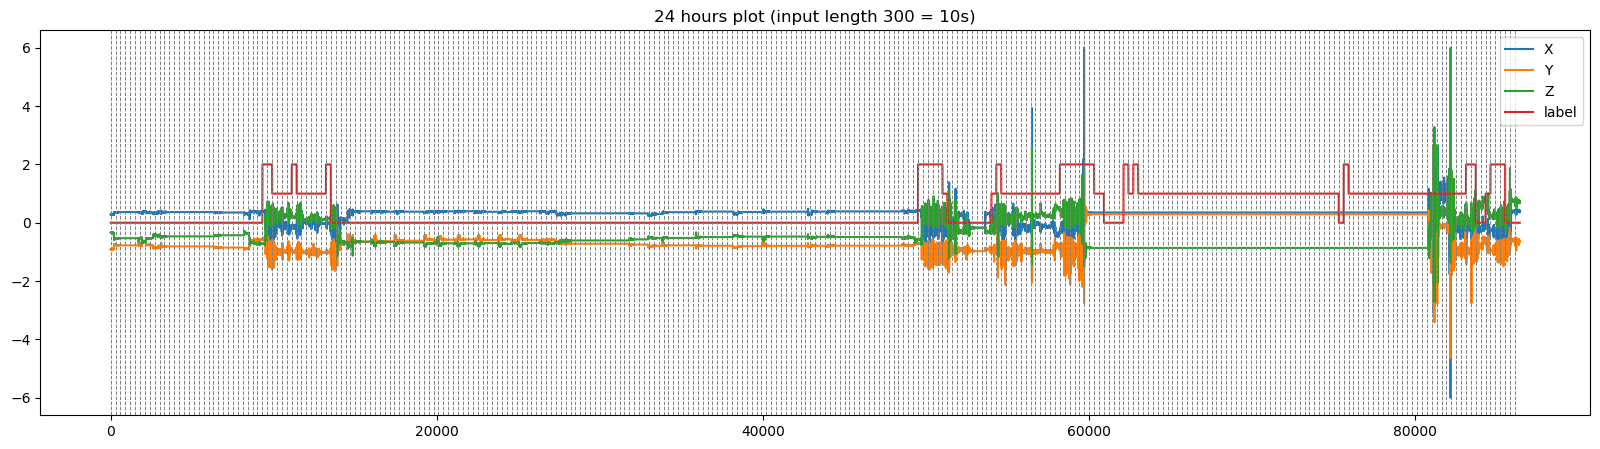

In [26]:
# n_hours hours plot


plt.figure(figsize=(20,5))
plt.plot(x_data_org, label="X")
plt.plot(y_data_org, label="Y")
plt.plot(z_data_org, label="Z")
plt.plot(label_data_org, label="label")
#plt.plot(id_data_org, label="id")
for x in range(0, x_data_org.shape[0], input_length):
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.7)
plt.legend()
plt.title(f"{n_hours} hours plot (input length {input_length} = {input_length//RISE_hz}s)")
plt.show()


label_names = ["sedentary", "standing", "stepping", "cycling", "primary_lying", "secondary_lying", "seated_transport"]

# standing and sedentary not very clearly defined

# x as absolute time in a day
# add predicted labels
# more research of -> consider dependence on neighboring windows/inputs
# xyz orientation or ActiGraph
# Leo ask orientation flip/compliance

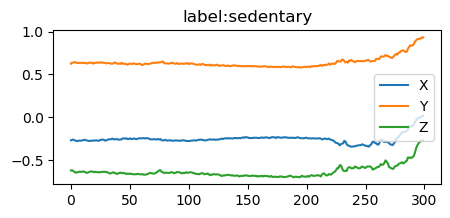

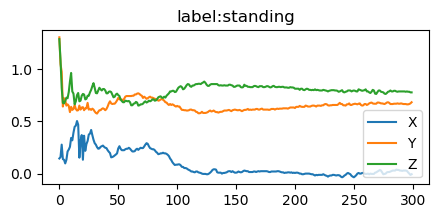

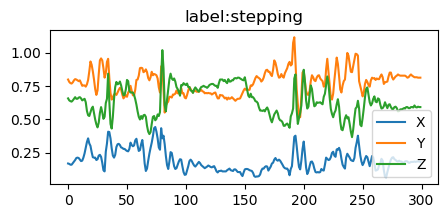

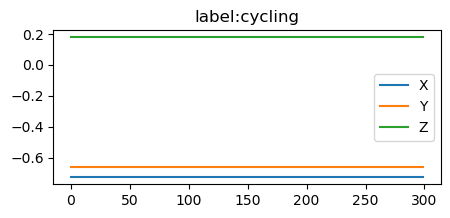

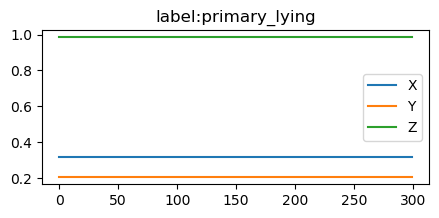

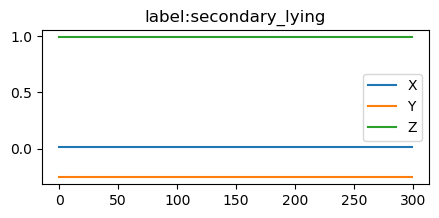

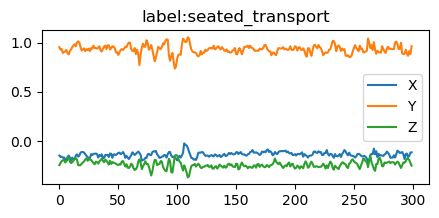

In [34]:
# individual look (k'th data for labels)
label_names = ["sedentary", "standing", "stepping", "cycling", "primary_lying", "secondary_lying", "seated_transport"]
k=150
for j in range(7):
    m = np.where(dataset.y == j)[0][k]
    data, label = dataset[m]
    #data1, label1 = dataset[m+1]
    plt.figure(figsize=(5,2))
    plt.plot(data[0,0,:], label="X")
    plt.plot(data[0,1,:], label="Y")
    plt.plot(data[0,2,:], label="Z")
    #plt.plot(np.repeat(label, data.shape[2]), label="label")
    plt.title(f"label:{label_names[j]}")
    plt.legend()
    plt.show()

# Reconstruction

In [ ]:
########### specify options
patch_size = [1, 60]
normalization=False
data_path ="/niddk-data-central/mae_hr/rise_moca_4AP_20s_transition"
test_data = True
transform=False
RISE_hz = 30
alt=True
data="RISE"
mask_ratio=0.75
use_transition_sub_label = False
RISE_bin_label = False
###########

In [ ]:
def load_dataset(data_path, data = "RISE", test_data=True, RISE_hz=30, alt=True, normalization=False, transform=False, use_transition_sub_label=False, RISE_bin_label=False):
    dataset = RISE(data_path=data_path, is_test=test_data, normalization=normalization,
                normalization_chan=False, RISE_hz=RISE_hz, mix_up=False, alt=alt, transform=transform,
                use_transition_sub_label=use_transition_sub_label, RISE_bin_label=RISE_bin_label)
    labels = ["sedentary", "standing", "stepping", "sleeping", "secondary_lying", "seated_transport"]

    if use_transition_sub_label:
        if RISE_bin_label:
            labels = ["sedentary", "active", "mixed"]
            activity_labels = {0.0: "sedentary", 0.1: "active", 0.2: "mixed"}
        else:
            labels = ["sedentary", "standing", "stepping", "lying", "seated_transport", "active_transition", "mixed_transition"]
            activity_labels = {0.0: "sedentary", 0.1: "standing", 0.2: "stepping", 0.3: "lying", 0.4: "seated_transport", 0.5: "active_transition", 0.6:"mixed_transition"}
    else:
        if RISE_bin_label:
            labels = ["sedentary", "active"]
            activity_labels = {0.0: "sedentary", 0.1: "active"}
        else:
            labels = ["sedentary", "standing", "stepping", "lying", "seated_transport", "transition"]
            activity_labels = {0.0: "sedentary", 0.1: "standing", 0.2: "stepping", 0.3: "lying", 0.4: "seated_transport", 0.5: "transition"}

    return dataset, labels, activity_labels


In [ ]:
# load data
dataset, labels, activity_labels = load_dataset(data_path=data_path, test_data=test_data, data=data alt=alt, normalization=normalization, transform=transform,
                                                use_transition_sub_label=use_transition_sub_label, RISE_bin_label=RISE_bin_label)


patch_num = None
patch_size1, patch_size2 = patch_size

input_size = [dataset[0][0].shape[1], dataset[0][0].shape[2]]

if int(input_size[1]/patch_size2) !=patch_num:
    patch_num = int(input_size[1]/patch_size2)


in_chans = dataset[0][0].shape[0]

print(f"input_size: {input_size}, patch_size:{patch_size}, patch_num: {patch_num}, in_chans: {in_chans}")
print("dataset shape", dataset.shape)




0/2 split loading
0/2 split done
1/2 split loading
1/2 split done
Data loading all done: # X test samples = 3533434
After Exclusion: # X test samples = 3532068
unique y: [0 1 2 3 4 5]
y shape: torch.Size([3532068])
input_size: [3, 600], patch_size:[1, 60], patch_num: 10, in_chans: 1
dataset shape [torch.Size([3532068, 1, 3, 600]), torch.Size([3532068])]


In [16]:
# load pre_trained model
checkpoint_path = "/niddk-data-central/mae_hr/RISE_PH/RISE_MoCA/experiments/RISE_pretrain_20s_none/137(RISE_pretrain_20s_none)/checkpoint-100.pth"

model_mae = load_model_pretrain(checkpoint_path=checkpoint_path, input_size=input_size,  patch_size=patch_size, finetune_interpolate_patches=False,
                                alt=True, in_chans=in_chans)

decoder_pos_embed shape BEFORE loading into model: torch.Size([1, 31, 512])
model expected shape: torch.Size([1, 31, 512])


test loss= 0.014(MSE), 0.192(nMSE)
torch.Size([1, 1, 600, 3]) torch.Size([1, 1, 600, 3]) torch.Size([1, 1, 600, 3]) torch.Size([1, 1, 600, 3])


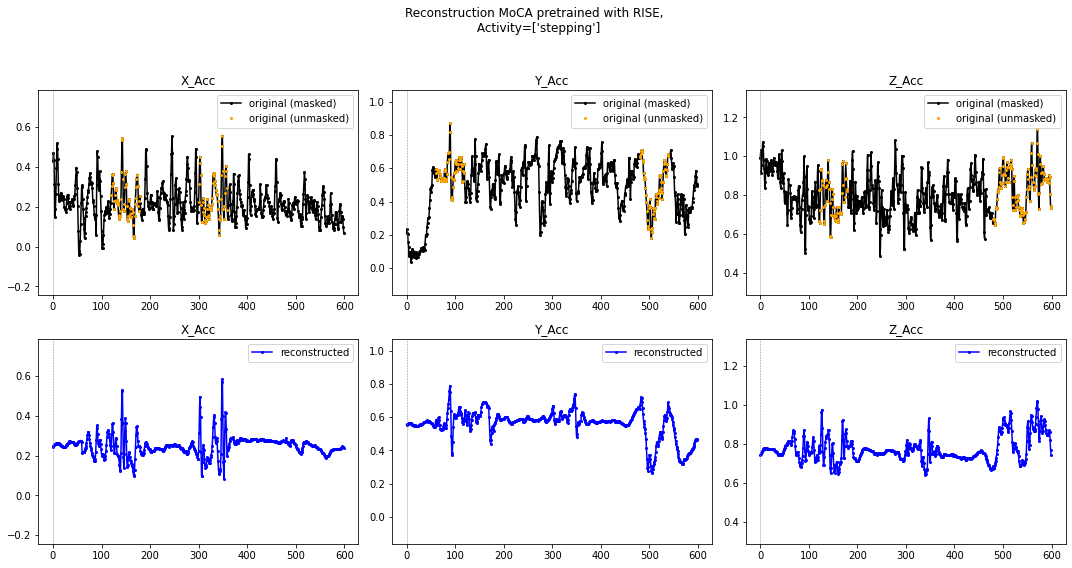

In [17]:
m=np.where(dataset.y == 2)[0][52]
n_inputs = 1
times=None
x =dataset.X[m:m+n_inputs]
labels = dataset.y[m:m+n_inputs]
if times != None:
    time_x = times[m:m+n_inputs]


title = "MoCA pretrained with RISE"
plot_reconstruction(model=model_mae, x=x, time_x=None, input_length=input_size[1], alt=True, mask_ratio=mask_ratio, norm_pix_loss=False,
                    title = title, marg = 0.2, linestyle="-",
                    activity_label=activity_labels, labels=labels, import_mask=None, seed=None, figsize=(15,8))

mask/unmask black shade in the background
overlay blue and black

## reconstruction of multiple inputs

In [ ]:
masked_all, paste_all, x_prime_all, y_all, x_squeeze_all, loss_MSE, loss_nMSE = mae_reconstruction_loop(model=model_mae,
                                                                                                        dataset=dataset, batch_size=100,
                                                                                                        mask_ratio=mask_ratio, alt=alt,
                                                                                                        norm_pix_loss=False, import_mask=None,
                                                                                                        device='cpu')

# Classification

In [ ]:
!python /niddk-data-central/mae_hr/RISE_PH/RISE_MoCA/submitit_finetune.py --eval --confusion_matrix_plot --use_transition_sub_label \
  --wk_dir "/niddk-data-central/mae_hr/RISE_PH/RISE_MoCA" --job_name "eval"  \
    --data_path "/niddk-data-central/mae_hr/rise_moca_4AP_20s_transition" --data "RISE" --RISE_hz 30 \
    --nodes 1 --batch_size 500 --epochs 20  \
    --cls_token --patch_size1 1 --patch_size2 60 --alt \
    --model vit_base_patch16 --nb_classes 7 \
    --plot_save_name "RISE_trans" --plot_title "RISE FT confusion matrix (7-classes)" \
    --resume "/niddk-data-central/mae_hr/RISE_PH/RISE_MoCA/experiments/RISE_FT_20s_none_trans/64(RISE_FT_20s_none_trans)/checkpoint-9.pth"


!python /niddk-data-central/mae_hr/RISE_PH/RISE_MoCA/submitit_finetune.py --eval --confusion_matrix_plot --RISE_bin_label \
  --wk_dir "/niddk-data-central/mae_hr/RISE_PH/RISE_MoCA" --job_name "eval"  \
    --data_path "/niddk-data-central/mae_hr/rise_moca_4AP_20s_transition" --data "RISE" --RISE_hz 30 \
    --nodes 1 --batch_size 500 --epochs 10  \
    --cls_token --patch_size1 1 --patch_size2 60 --alt \
    --model vit_base_patch16 --nb_classes 2 \
    --plot_save_name "RISE_none_bin" --plot_title "RISE FT confusion matrix (2-classes)" \
    --resume "/niddk-data-central/mae_hr/RISE_PH/RISE_MoCA/experiments/RISE_FT_20s_none_bin/48(RISE_FT_20s_none_bin)/checkpoint-9.pth"


# For prediction labels
!python /niddk-data-central/mae_hr/RISE_PH/RISE_MoCA/submitit_finetune.py --eval --use_transition_sub_label \
  --wk_dir "/niddk-data-central/mae_hr/RISE_PH/RISE_MoCA" --job_name "eval" --save_predictions  --train_eval \
    --data_path "/niddk-data-central/mae_hr/rise_moca_4AP_20s_transition" --data "RISE" --RISE_hz 30 \
    --nodes 1 --batch_size 500 --epochs 20  \
    --cls_token --patch_size1 1 --patch_size2 60 --alt \
    --model vit_base_patch16 --nb_classes 7 \
    --plot_save_name "none_trans" --plot_title "RISE FT confusion matrix (7-classes)" \
    --resume "/niddk-data-central/mae_hr/RISE_PH/RISE_MoCA/experiments/RISE_FT_20s_none_trans/64(RISE_FT_20s_none_trans)/checkpoint-9.pth"

!python /niddk-data-central/mae_hr/RISE_PH/RISE_MoCA/submitit_finetune.py --eval --use_transition_sub_label --RISE_bin_label \
  --wk_dir "/niddk-data-central/mae_hr/RISE_PH/RISE_MoCA" --job_name "eval" --save_predictions  \
    --data_path "/niddk-data-central/mae_hr/rise_moca_4AP_20s_transition" --data "RISE" --RISE_hz 30 \
    --nodes 1 --batch_size 500 --epochs 20  \
    --cls_token --patch_size1 1 --patch_size2 60 --alt \
    --model vit_base_patch16 --nb_classes 3 \
    --plot_save_name "none_trans_bin" --plot_title "RISE FT confusion matrix (3-classes)" \
    --resume "/niddk-data-central/mae_hr/RISE_PH/RISE_MoCA/experiments/RISE_FT_20s_none_trans_bin/64(RISE_FT_20s_none_trans_bin)/checkpoint-9.pth"



/opt/conda/lib/python3.8/site-packages/apex/pyprof/__init__.py:5: FutureWarning: pyprof will be removed by the end of June, 2022
  warnings.warn("pyprof will be removed by the end of June, 2022", FutureWarning)
Submitted job_id: 11501


In [3]:
########### specify options
patch_size = [1, 60]
normalization=False
data_path ="/niddk-data-central/mae_hr/rise_moca_4AP_20s_transition"
test_data = True
data = "RISE"
transform=False
RISE_hz = 30
alt=True
mask_ratio=0.75
use_transition_sub_label = True
RISE_bin_label = False
device='cuda'
batch_size = 30
###########

In [4]:
dataset_train, label_test, activity_labels = load_dataset(data_path=data_path, data=data, test_data=False, alt=True, 
                                                use_transition_sub_label=use_transition_sub_label, RISE_bin_label=RISE_bin_label)
dataset_test, labels_test, activity_labels = load_dataset(data_path=data_path, data=data, test_data=True, alt=True, 
                                                use_transition_sub_label=use_transition_sub_label, RISE_bin_label=RISE_bin_label)

patch_num = None
patch_size1, patch_size2 = patch_size

input_size = [dataset_train[0][0].shape[1], dataset_train[0][0].shape[2]]

if int(input_size[1]/patch_size2) !=patch_num:
    patch_num = int(input_size[1]/patch_size2)


in_chans = dataset_train[0][0].shape[0]
input_length = input_size[1]
print(f"input_size: {input_size}, patch_size:{patch_size}, patch_num: {patch_num}, in_chans: {in_chans}")
print("dataset shape", dataset_train.shape, dataset_test.shape)


classification_checkpoint_path = "/niddk-data-central/mae_hr/RISE_PH/RISE_MoCA/experiments/RISE_FT_20s_none_trans/64(RISE_FT_20s_none_trans)/checkpoint-9.pth"
classification_model = load_model_ft(checkpoint_path=classification_checkpoint_path, LP=False, nb_classes=7, in_chans=in_chans, input_size=input_size, patch_size=patch_size,
                                     finetune_interpolate_patches=False, device=device)
classification_model = classification_model.to(device)

preds_list_train, targets_list_train, acc1_train = mae_classification_pass(dataset_train, classification_model, batch_size=10, device=device)
preds_list_test, targets_list_test, acc1_test = mae_classification_pass(dataset_test, classification_model, batch_size=10, device=device)

torch.save(torch.tensor(preds_list_train), f'/niddk-data-central/mae_hr/rise_moca_4AP_20s_transition/none_trans_pred_train.pt')
torch.save(torch.tensor(preds_list_test), f'/niddk-data-central/mae_hr/rise_moca_4AP_20s_transition/none_trans_pred_test.pt')

0/3 split loading
0/3 split done
1/3 split loading
1/3 split done
2/3 split loading
2/3 split done
Data loading all done: # X train samples = 8054286
After Exclusion: # X train samples = 8050860
unique y: [0 1 2 3 4 5 6]
y shape: torch.Size([8050860])
0/2 split loading
0/2 split done
1/2 split loading
1/2 split done
Data loading all done: # X test samples = 3533434
After Exclusion: # X test samples = 3532068
unique y: [0 1 2 3 4 5 6]
y shape: torch.Size([3532068])
input_size: [3, 600], patch_size:[1, 60], patch_num: 10, in_chans: 1
dataset shape [torch.Size([8050860, 1, 3, 600]), torch.Size([8050860])] [torch.Size([3532068, 1, 3, 600]), torch.Size([3532068])]
<All keys matched successfully>


KeyboardInterrupt: 

In [6]:
preds_list_test, targets_list_test, acc1_test = mae_classification_pass(dataset_test, classification_model, batch_size=100, device=device)
torch.save(torch.tensor(preds_list_test), f'/niddk-data-central/mae_hr/rise_moca_4AP_20s_transition/none_trans_pred_test.pt')

KeyboardInterrupt: 

# Vsualization: superimposed classification prediction and reconstruction

In [2]:
########### specify options
patch_size = [1, 60]
normalization=False
data_path ="/niddk-data-central/mae_hr/rise_moca_4AP_20s_transition"
test_data = True
data = "RISE"
transform=False
RISE_hz = 30
alt=True
mask_ratio=0.75
use_transition_sub_label = True
RISE_bin_label = False
device='cuda'
batch_size = 10
###########

In [3]:
# load data
dataset, labels, activity_labels = load_dataset(data_path=data_path, data=data, test_data=test_data, alt=alt, normalization=normalization, transform=transform,
                                                use_transition_sub_label=use_transition_sub_label, RISE_bin_label=RISE_bin_label)

patch_num = None
patch_size1, patch_size2 = patch_size

input_size = [dataset[0][0].shape[1], dataset[0][0].shape[2]]

if int(input_size[1]/patch_size2) !=patch_num:
    patch_num = int(input_size[1]/patch_size2)


in_chans = dataset[0][0].shape[0]
input_length = input_size[1]
print(f"input_size: {input_size}, patch_size:{patch_size}, patch_num: {patch_num}, in_chans: {in_chans}")
print("dataset shape", dataset.shape)

0/2 split loading
0/2 split done
1/2 split loading
1/2 split done
Data loading all done: # X test samples = 3533434
After Exclusion: # X test samples = 3532068
unique y: [0 1 2 3 4 5 6]
y shape: torch.Size([3532068])
input_size: [3, 600], patch_size:[1, 60], patch_num: 10, in_chans: 1
dataset shape [torch.Size([3532068, 1, 3, 600]), torch.Size([3532068])]


In [119]:
# load models
pretrained_checkpoint_path = "/niddk-data-central/mae_hr/RISE_PH/RISE_MoCA/experiments/RISE_pretrain_20s_none/137(RISE_pretrain_20s_none)/checkpoint-100.pth"
model_mae = load_model_pretrain(checkpoint_path=pretrained_checkpoint_path, input_size=input_size,  patch_size=patch_size, finetune_interpolate_patches=False,
                                alt=True, in_chans=in_chans)
model_mae = model_mae.to(device)


classification_checkpoint_path = "/niddk-data-central/mae_hr/RISE_PH/RISE_MoCA/experiments/RISE_FT_20s_none_trans/64(RISE_FT_20s_none_trans)/checkpoint-9.pth"
classification_model = load_model_ft(checkpoint_path=classification_checkpoint_path, LP=False, nb_classes=7, in_chans=in_chans, input_size=input_size, patch_size=patch_size,
                                     finetune_interpolate_patches=False, device=device)
classification_model = classification_model.to(device)
                                     



decoder_pos_embed shape BEFORE loading into model: torch.Size([1, 31, 512])
model expected shape: torch.Size([1, 31, 512])
<All keys matched successfully>


In [126]:
# get predictions for the subsample
from torch.utils.data import Subset

m = 10
n_idx = 3652
start_idx = np.where(dataset.y == 2)[0][n_idx]

#search by batch_idx
#batch_idx = 7470-1
#batch_size=300
#start_idx = batch_idx*batch_size

# subset data
indices = list(range(start_idx, start_idx + m))
dataset_sub = Subset(dataset, indices)


preds_list, targets_list, acc1 = mae_classification_pass(dataset_sub, classification_model, batch_size=10, device=device)
masked_all, paste_all, x_prime_all, y_all, x_squeeze_all, loss_MSE, loss_nMSE = mae_reconstruction_loop(model=model_mae,
                                                                                                        dataset=dataset_sub, batch_size=10,
                                                                                                        mask_ratio=mask_ratio, alt=alt,
                                                                                                        norm_pix_loss=False, import_mask=None,
                                                                                                        device=device)
print(masked_all.shape)


masked = masked_all.reshape(input_length*m,3).unsqueeze(0).unsqueeze(0).cpu()
paste = paste_all.reshape(input_length*m,3).unsqueeze(0).unsqueeze(0).cpu()
x_prime = x_prime_all.reshape(input_length*m,3).unsqueeze(0).unsqueeze(0).cpu()
y = y_all.reshape(input_length*m,3).unsqueeze(0).unsqueeze(0).cpu()
x_squeeze = x_squeeze_all.reshape(input_length*m,3).unsqueeze(0).unsqueeze(0).cpu()

preds_all = np.repeat(preds_list, input_length)/10
targets_all = np.repeat(targets_list, input_length)/10

#sanity check
#l=3
#plt.plot(masked_all[l,0,:,0])
#plt.plot(masked_all_concat[0,0,l*300:(l+1)*300,0])
#plt.show()



torch.Size([10, 1, 600, 3])


Reconstruction and Classification plot

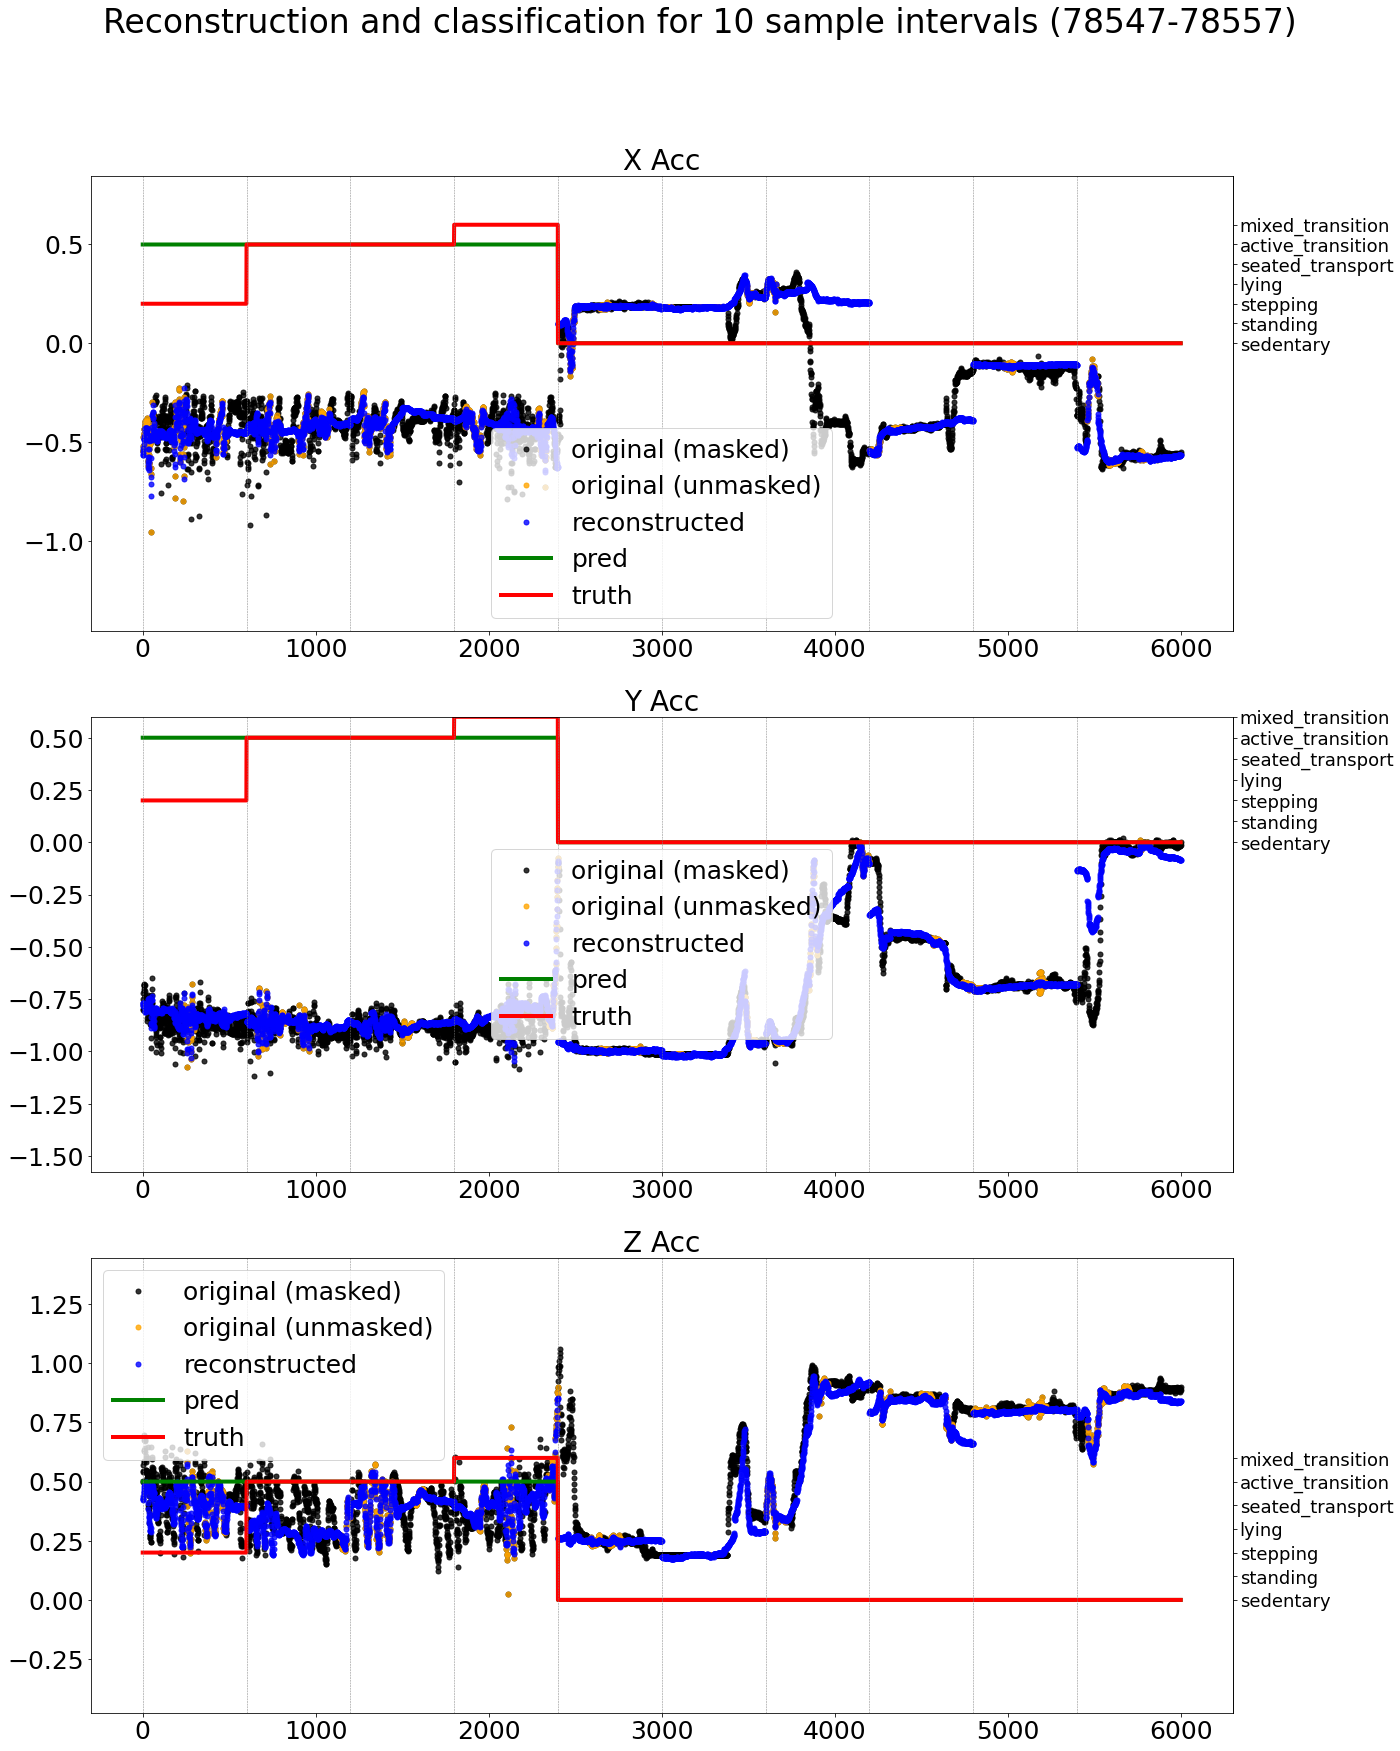

In [127]:
figsize=(20, 25)
linestyle=""
marg=0.5
#ylim = [-1.3, 1.3]
ms = 2
linestyle_unmasked = ''

modalities = ["Acc"]
axes = ["X", "Y", "Z"]
fig, axs = plt.subplots(len(axes), len(modalities), figsize=figsize)  # only 1 row per modality
plt.rcParams.update({'font.size': 25})

fs_default = 13

for i, modal in enumerate(modalities):
    for j, ax in enumerate(axes):

        # --- Overlay all signals on the same subplot ---
        axs[j].plot(x_prime[0, 0, :, 3*i+j], label="original (masked)", 
                    color="black", marker='o', alpha=0.8, linestyle=linestyle, markersize=ms+3)

        unmasked_x = masked[0, 0, :, 3*i+j] != 0
        indices_x = np.where(unmasked_x)[0]
        axs[j].plot(indices_x, masked[0,0,unmasked_x,3*i+j], label="original (unmasked)", 
                    color="orange", marker='o', alpha=0.8, linestyle=linestyle_unmasked, markersize=ms+3)

        axs[j].plot(y[0,0,:,3*i+j], label="reconstructed", 
                    color="blue", marker='o', alpha=0.8, linestyle=linestyle, markersize=ms+3)

        axs[j].plot(preds_all, label="pred", color="green", linewidth=4)
        axs[j].plot(targets_all, label="truth", color="red", linewidth=4)

        # formatting
        axs[j].legend()
        axs[j].set_title(f"{ax} {modal}", fontsize=fs_default+15)
        org_unmasked = masked[0,0,unmasked_x,3*i+j]
        org_masked = x_prime[0, 0, :, 3*i+j]
        reconstructed = y[0,0,:,3*i+j]
        ul = max([  max(org_unmasked)+marg, max(org_unmasked)+marg, max(reconstructed)+marg, 0.6])
        ll = min([ min(org_unmasked)-marg, min(org_unmasked)-marg, min(reconstructed)-marg, -0.1])
        axs[j].set_ylim([ll, ul])

        # activity labels as secondary axis
        secax = axs[j].secondary_yaxis('right')
        secax.set_yticks(list(activity_labels.keys()))
        secax.set_yticklabels(list(activity_labels.values()), fontsize=fs_default+5)
        #secax.set_ylabel("Activity", fontsize=fs_default+10)

        # patch boundaries
        for k in range(0, masked.shape[2], input_length):
            axs[j].axvline(x=k, color='gray', linestyle='--', linewidth=0.5)

#plt.suptitle(f"{start_idx/300} to {(start_idx+m)/300}")
#plt.suptitle(f"{start_idx} to {start_idx+m}")
plt.suptitle(f"Reconstruction and classification for {m} sample intervals ({start_idx}-{start_idx+m})", fontsize=fs_default+20)
plt.subplots_adjust(hspace=0.2, top=0.9)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
figsize=(100, 20)
linestyle=""
marg=0.2
ylim = [-1.5, 1.2]


# y limits
y_squeeze = y.squeeze(dim=0).squeeze(dim=0)
all_data = torch.cat((y, x_prime), dim=0)
ymin_lims = torch.amin(all_data, dim=(0, 1, 2))
ymax_lims = torch.amax(all_data, dim=(0, 1, 2))
ms = 2
linestyle_unmasked = ''
modalities = ["Acc"]
axes = ['X', "Y", "Z"]
fig, axs = plt.subplots(len(modalities)*2, len(axes), figsize=figsize)
plt.rcParams.update({'font.size': 25})
for i, modal in enumerate(modalities):
    for j, ax in enumerate(axes):
        # xaxis
        axs[2*i,j].plot(x_prime[0, 0, :, 3*i+j], label="original (masked)", color="black", marker='o', linestyle=linestyle, markersize=ms) # original but will be painted over by un_masked
        unmasked_x = masked[0, 0, :, 3*i+j] != 0
        indices_x = np.where(masked[0, 0, :, 3*i+j] != 0)[0]
        axs[2*i,j].plot(indices_x, masked[0,0,unmasked_x,3*i+j], label="original (unmasked)", color="orange", marker='o', linestyle=linestyle_unmasked, markersize=ms)
        axs[2*i,j].plot(targets_all, label="truth", color="red")
        axs[2*i,j].legend()
        axs[2*i,j].set_title(f"{ax}_{modal}")
        #axs[2*i,j].set_ylim([ymin_lims[3*i+j]-marg, ymax_lims[3*i+j]+marg])
        axs[2*i,j].set_ylim(ylim)
        

        axs[2*i+1,j].plot(y[0,0,:,3*i+j], label="reconstructed", color="blue", marker='o', linestyle=linestyle, markersize=ms)
        #axs[i,j].plot(paste[0,0,:,i], label="reconstruction + visible")
        axs[2*i+1,j].plot(preds_all, label="pred", color="red")
        
        axs[2*i+1,j].legend()
        axs[2*i+1,j].set_title(f"{ax}_{modal}")
        #axs[2*i+1,j].set_ylim([ymin_lims[3*i+j]-marg, ymax_lims[3*i+j]+marg])
        axs[2*i+1,j].set_ylim(ylim)
        for k in range(0, masked.shape[2], input_length):
            axs[2*i, j].axvline(x=k, color='gray', linestyle='--', linewidth=0.5)
            axs[2*i+1, j].axvline(x=k, color='gray', linestyle='--', linewidth=0.5)

        # secondary y-axis (right) for categorical activity labels
        secax = axs[2*i,j].secondary_yaxis('right')
        secax.set_yticks(list(activity_labels.keys()))
        secax.set_yticklabels(list(activity_labels.values()), fontsize=18)
        secax.set_ylabel("Activity", fontsize=20)

        # reconstruction plot as well
        axs[2*i+1,j].set_ylim(ylim)
        secax2 = axs[2*i+1,j].secondary_yaxis('right')
        secax2.set_yticks(list(activity_labels.keys()))
        secax2.set_yticklabels(list(activity_labels.values()), fontsize=18)
        secax2.set_ylabel("Activity", fontsize=20)

        



#plt.suptitle(f"RISE: acc={acc1}")
#plt.suptitle(f"{start_idx/batch_size} to {(start_idx+m)/batch_size}")
plt.suptitle(f"{start_idx} to {start_idx+m}")
plt.subplots_adjust(hspace=0.1, top=0.9)
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()